In [1]:
from google.cloud import bigquery
from google.oauth2 import service_account
import warnings

In [2]:
# Realizar conexão com o GCP
credentials = service_account.Credentials.from_service_account_file("../keys/ml-na-saude-ed1fc3c1a83e.json")
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

In [3]:
consulta_sql = """
select
  case
    when extract(month from taxa.dt_obito) between 1 and 4 then date(extract(year from taxa.dt_obito), 1, 1)
    when extract(month from taxa.dt_obito) between 5 and 8 then date(extract(year from taxa.dt_obito), 5, 1)
    when extract(month from taxa.dt_obito) between 9 and 12 then date(extract(year from taxa.dt_obito), 9, 1)
    end as quadrimestre,
  avg(taxa.taxa_yll) as taxa_media_yll
from (
  select
    m.nm_municipio,
    y.dt_obito,
   SUM(y.yll) / AVG(p.populacao) * 1000 AS taxa_yll
  from `ml-na-saude.yll_por_obito.yll` y
  join `ml-na-saude.yll_por_obito.populacao` p on y.cd_mun_res = p.cd_municipio and y.ano_obito = p.ano
  join `ml-na-saude.yll_por_obito.municipio` m on p.cd_municipio = m.cd_municipio
  where p.porte = 'Médio Porte'
  group by 1,2
) taxa
group by 1
order by 1
"""

In [26]:
warnings.simplefilter("ignore")
df = client.query(consulta_sql).to_dataframe()

In [27]:
df

,quadrimestre,taxa_media_yll
0,2010-01-01,0.360811
1,2010-05-01,0.355732
2,2010-09-01,0.347550
3,2011-01-01,0.348310
4,2011-05-01,0.346038
5,2011-09-01,0.336318
6,2012-01-01,0.340401
7,2012-05-01,0.341911
8,2012-09-01,0.335028
9,2013-01-01,0.340162


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [29]:
df['quadrimestre'] = pd.to_datetime(df['quadrimestre'])
df.set_index('quadrimestre', inplace=True)

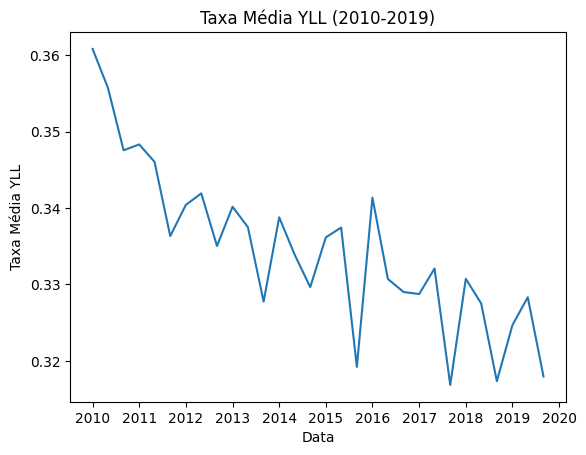

In [30]:
plt.plot(df['taxa_media_yll'])
plt.title('Taxa Média YLL (2010-2019)')
plt.xlabel('Data')
plt.ylabel('Taxa Média YLL')
plt.show()

In [31]:
def teste_adf(serie):
    result = adfuller(serie)
    print('ADF Estatíticas: %f' % result[0])
    print('Valor de P: %f' % result[1])
    print('Valores Críticos:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if result[1] < 0.05:
        print("A série é estacionária.")
    else:
        print("A série não é estacionária.")

In [32]:
# Executa o teste de estacionaridade em 'taxa_yll'
X = df['taxa_media_yll']
teste_adf(X)

ADF Estatíticas: -1.575026
Valor de P: 0.496125
Valores Críticos:
	1%: -3.738
	5%: -2.992
	10%: -2.636
A série não é estacionária.


In [33]:
# Diferenciação simples
df['taxa_media_yll_diff'] = df['taxa_media_yll'].diff().dropna()

# Verifica novamente a estacionaridade após a diferenciação
teste_adf(df['taxa_media_yll_diff'].dropna())

ADF Estatíticas: -3.238749
Valor de P: 0.017848
Valores Críticos:
	1%: -3.738
	5%: -2.992
	10%: -2.636
A série é estacionária.


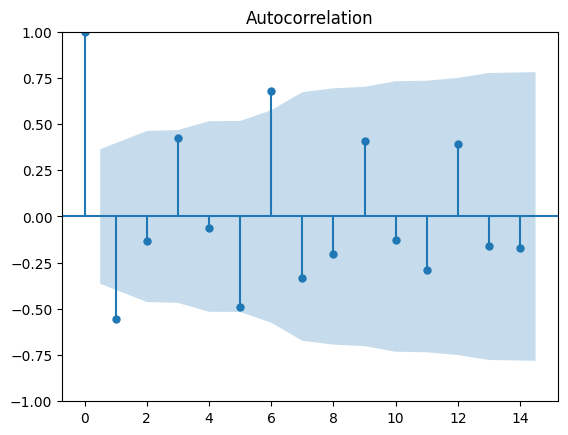

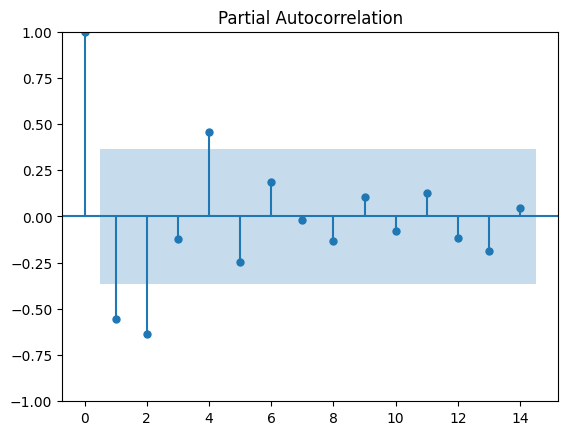

In [34]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Gráfico ACF
plot_acf(df['taxa_media_yll_diff'].dropna())
plt.show()

# Gráfico PACF
plot_pacf(df['taxa_media_yll_diff'].dropna())
plt.show()

ARIMA

In [42]:
from pmdarima import auto_arima

auto_model = auto_arima(df['taxa_media_yll'], seasonal=False, trace=True)
print(auto_model.summary())

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model_arima = ARIMA(df['taxa_media_yll'], order=(p, d, q))  # Ajuste os valores de p, d e q
arima_fit = model_arima.fit()